<a id='top'></a>
<h1 align="center">MCMC Tutorial Part 2A</h1>

<br>

**Authors:** John Letey, Mingxuan Zhang, and Tony E Wong

### Table of Contents

- [Packages](#packages)
- [Generate Synthetic Data](#synthetic-data)
- [Log-Likelihood Function](#log-likelihood)
- [Log-Prior Distribution](#log-prior)
- [Log-Posterior Distribution](#log-posterior)
- [Adaptive Metropolis-Hastings Algorithm](#amha)
- [Gelman-Rubin Diagnostic](#gr-diagnostic)
- [Running the Algorithm](#run-algo)
- [Diagnostic Plots](#diagnostic-plots)

<a id='packages'></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

<br>

These are all of the packages we are going to be using:

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
# %load_ext blackcellmagic

***

<a id='synthetic-data'></a>
***
<h2 align="center">Generate Synthetic Data</h2>
[Back to top](#top)

<br>

Since this tutorial is focused on the fact that we're fitting a normal distribution given that we have some known parameters, lets first generate the random normal distribution that we are going to fit given parameters $\mu = 10$ and $\sigma = 10$:

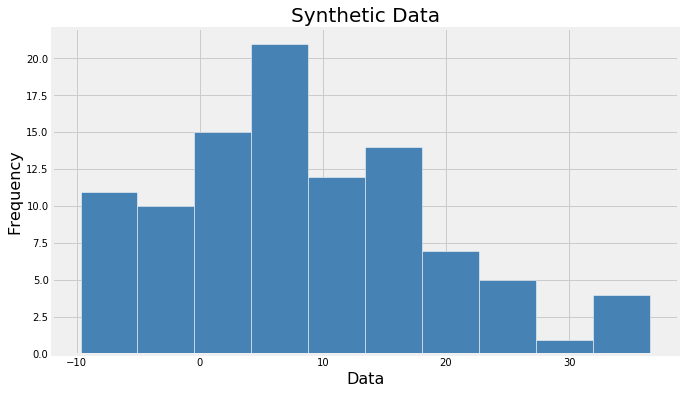

In [2]:
def generate_synthetic_data(mu, sigma, plot=False):
    data_meas = stats.norm.rvs(loc=mu, scale=sigma, size=100)
    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(data_meas, facecolor="steelblue", edgecolor="white")
        plt.title("Synthetic Data", fontsize=20)
        plt.xlabel("Data", fontsize=16)
        plt.ylabel("Frequency", fontsize=16)
        plt.axis(alpha=.5)
        plt.show()
    return data_meas


mu_param, sigma_param = 10, 10
data_meas = generate_synthetic_data(mu_param, sigma_param, True)

***

<a id='log-likelihood'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

In [3]:
def likelihood(parameters, data_meas=data_meas):
    u, s = parameters
    prod = 1
    for i in range(len(data_meas)):
        pdf = stats.norm.pdf(x=data_meas[i], loc=u, scale=s)
        if pdf == 0:
            return -np.inf
        prod += np.log(pdf)
    return prod

***

<a id='log-prior'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

In [4]:
def prior(parameters):
    u, s = parameters
    mu_pdf = stats.norm.pdf(x=u, loc=0, scale=1000)
    if s >= 1000 or s <= 0 or mu_pdf == 0:
        return -np.inf
    else:
        return np.log(mu_pdf) + np.log(1 / 1000)

***

<a id='log-posterior'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

In [5]:
def logpost(parameters, data_meas=data_meas):
    pi = prior(parameters)
    if pi == -np.inf:
        return -np.inf
    L = likelihood(parameters, data_meas)
    return L + pi

***

<a id='amha'></a>
***
<h2 align="center">Adaptive Metropolis-Hastings Algorithm</h2>
[Back to top](#top)

<br>

The Adaptive Metropolis (AM) algorithm of Haario et al. (2001) is an extension of the Metropolis-Hastings algorithm that adapts based on the observed covariance matrix from the history of the chains. AM is historically significant as the first adaptive MCMC algorithm.

In [6]:
def runner(
    m, n_iter, data_meas=data_meas, logpost=logpost, t=1000, stepsize=[0.01, 0.01]
):
    # set up the different chains
    chains = []
    for i in range(m):
        mu_init = np.random.randint(low=6, high=12)
        sigma_init = np.random.randint(low=1, high=5)
        theta = [mu_init, sigma_init]
        state = State(theta, logpost(theta, data_meas))
        chains.append(ProblemMCMC(state, logpost, stepsize, data_meas, t))
    # run the algorithm on all of the chains
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        mu, sigma, l, r = AdaptiveMCMC(chains[i], n_iter)
        mcmc_chains.append([mu, sigma])
        ar.append(r)
        ls.append(l)
    # return
    return mcmc_chains, ar, ls

In [8]:
eps = 0.0001
d = 2
I_d = np.identity(d)
S_d = (2.4) ** 2 / d


def update_cov(X):
    cov = np.cov(X)
    return S_d * cov + I_d * eps * S_d


class State:
    def __init__(self, state, value):
        self.state = state
        self.value = value


class ProblemMCMC:
    def __init__(self, initial, logposterior, stepsize, data_measa, t):
        self.current = initial
        self.logpost = logposterior
        self.stepsize = stepsize
        self.data_meas = data_meas
        self.t = t

    def random_move(self, t, X):
        if t <= self.t:
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [9]:
def AdaptiveMCMC(problem, n_iter):
    u, s = [problem.current.state[0]], [problem.current.state[1]]
    lpost = [problem.current.value]
    n_accept = 0
    S = 0
    np.seterr(over="ignore")
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move(t, [u, s])
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            n_accept += 1
            u.append(nextMove[0])
            s.append(nextMove[1])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1 - p_accept])
            if accept:
                n_accept += 1
                u.append(nextMove[0])
                s.append(nextMove[1])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                u.append(u[-1])
                s.append(s[-1])
                lpost.append(lpost[-1])

    return (u, s, lpost, n_accept / S)

***

<a id='gr-diagnostic'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic</h2>
[Back to top](#top)

In [10]:
def GR_diag(parameter, interval=100, start=100, plot=False):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    x_range = []
    for n in range(start, end, interval):
        x_range.append(n)
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i + 1
            break
    if plot:
        plt.figure(figsize=(14, 6))
        plt.scatter(x=x_range, y=GR_result, label="GR diagnostic", color="steelblue")
        plt.vlines(
            burnin * interval,
            ymin=1,
            ymax=max(GR_result),
            label="burn in={0}".format(burnin * interval),
        )
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Potential Scale Reduction Fator", fontsize=14)
        plt.title("Gelman & Rubin Diagnostic", fontsize=14)
        plt.legend(loc="best")
        plt.show()
    return GR_result, burnin * interval


def psrf(sequences):
    u = [np.mean(sequence) for sequence in sequences]
    s = [np.var(sequence, ddof=1) for sequence in sequences]
    m = len(sequences)
    n = len(sequences[0])
    U = np.mean(u)
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - U) ** 2
        W += s[i]
    B = (B * n) / (m - 1)
    W = W / m
    Var = (1 - (1 / n)) * W + (B / n)
    return np.sqrt(Var / W)

***

<a id='ac-function'></a>
***
<h2 align="center">Auto-Correlation Function</h2>
[Back to top](#top)

In [11]:
def ACF(X, end=200, interval=1, plot=False):
    N = len(X)
    acf = []
    x_range = []
    for a in range(0, end, interval):
        x_range.append(a)
        acf.append(np.corrcoef(X[a:], X[: N - a])[0][1])

    lag = 0
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if plot:
        plt.figure(figsize=(8, 6))
        plt.stem(x_range, acf, label="ACF")
        plt.vlines(x=lag, ymin=0, ymax=1, label="lag = {0}".format(lag))
        plt.xlabel("Lag", fontsize=12)
        plt.ylabel("ACF", fontsize=12)
        plt.legend(loc="best")
        plt.show()
    return lag

***

<a id='run-algo'></a>
***
<h2 align="center">Running the Algorithm</h2>
[Back to top](#top)

<br>

Finally, we can start the Adaptive MCMC algorithm... we will generate three sequences each with 10000 iterations:

In [12]:
t=100
mcmc_chains, ar, ls = runner(m=3, n_iter=10000, t=t, data_meas=data_meas)

<br>

Again, let us take a look at the history plots first for each parameter:

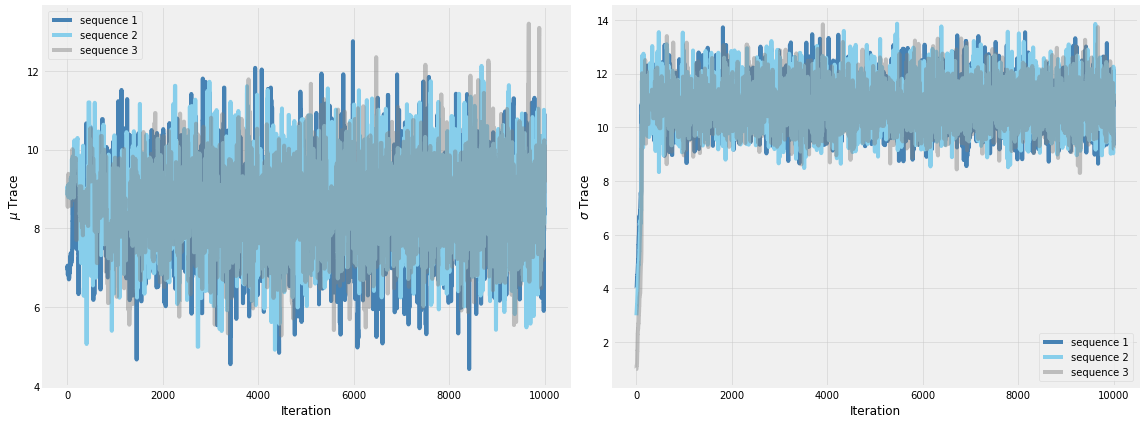

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(mcmc_chains[0][0], label='sequence 1', color='steelblue')
ax[0].plot(mcmc_chains[1][0], label='sequence 2', color='skyblue')
ax[0].plot(mcmc_chains[2][0], label='sequence 3', color='gray', alpha=0.45)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$\mu$ Trace")
ax[0].legend(loc='best')
ax[0].grid(alpha=0.5)


ax[1].plot(mcmc_chains[0][1], label='sequence 1', color='steelblue')
ax[1].plot(mcmc_chains[1][1], label='sequence 2', color='skyblue')
ax[1].plot(mcmc_chains[2][1], label='sequence 3', color='gray', alpha=0.45)
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$\sigma$ Trace")
ax[1].legend(loc='best')
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

<br>

Now, let us use the GR diagnostic to find the burn in period:

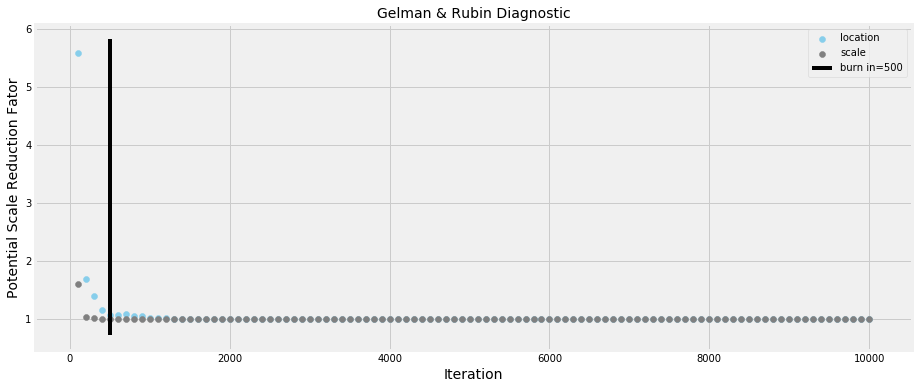

In [15]:
u_raw, s_raw =[], []

for mcmc_chain in mcmc_chains:
    u_raw.append(mcmc_chain[0])
    s_raw.append(mcmc_chain[1])

start, interval, end = 100, 100, len(u_raw[0])

GR_u, burnin_u = GR_diag(u_raw, interval, start)

GR_s, burnin_s = GR_diag(s_raw, interval, start)

burnin = max([burnin_u, burnin_s, t])

plt.figure(figsize=(14, 6))
plt.scatter(x=np.arange(start, end, interval), y=GR_u, label='location', color='skyblue')
plt.scatter(x=np.arange(start, end, interval), y=GR_s, label='scale', color='gray')
ymin, ymax = plt.ylim()
plt.vlines(burnin, ymin=ymin, ymax=ymax, label='burn in={0}'.format(burnin))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Potential Scale Reduction Fator', fontsize=14)
plt.title('Gelman & Rubin Diagnostic', fontsize=14)
plt.legend(loc='best')
plt.show()

<br>

Let us also use Thinning to find the lag for each chain:

In [20]:
len(u_raw[i][burnin:])

9501

In [22]:
lag_u = []
lag_s = []

acf_u = []
acf_s = []

end = 100
for i in range(len(u_raw)):
    u_lag, u_acf = ACF(u_raw[i][burnin:], end)
    s_lag, s_acf = ACF(s_raw[i][burnin:], end)
    
    lag_u.append(u_lag)
    lag_s.append(s_lag)
    
    acf_u.append(u_acf)
    acf_s.append(s_acf)
    
    
lags = [max([lag_u[i], lag_s[i]]) for i in range(len(u_raw))]


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax[0].stem(np.arange(0, end), acf_u[0], label='location')
ax[0].stem(np.arange(0, end), acf_s[0], label='scale')
ax[0].vlines(x=lags[0], ymin=0, ymax=1, label='lag = {0}'.format(lags[0]))
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("ACF")
ax[0].set_title("Sequence 1")
ax[0].legend(loc='best')
ax[0].grid(alpha=0.5)

ax[1].stem(np.arange(0, end), acf_u[1], label='location')
ax[1].stem(np.arange(0, end), acf_s[1], label='scale')
ax[1].vlines(x=lags[1], ymin=0, ymax=1, label='lag = {0}'.format(lags[2]))
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("ACF")
ax[1].set_title("Sequence 2")
ax[1].legend(loc='best')
ax[1].grid(alpha=0.5)

ax[2].stem(np.arange(0, end), acf_u[2], label='location')
ax[2].stem(np.arange(0, end), acf_s[2], label='scale')
ax[2].vlines(x=lags[2], ymin=0, ymax=1, label='lag = {0}'.format(lags[2]))
ax[2].set_xlabel("Lag")
ax[2].set_ylabel("ACF")
ax[2].set_title("Sequence 3")
ax[2].legend(loc='best')
ax[2].grid(alpha=0.5)

plt.tight_layout()
plt.show()

TypeError: 'int' object is not iterable

<br>

Finally, let's merge all sequences into one final parameter sets pool:

In [24]:
# merge the parameters

n_iter = len(u_raw[0])

m = len(u_raw)

# this is the final list for location parameter
u_analysis = [] 

# this is the final list for scale parameter
s_analysis = []

# this is a list of tuples, each tupel is in this format (location, scale)
params_analysis = []


# merge all three sequences 
for i in range(m):
    for j in range(burnin, n_iter, lags[i]):
        u_analysis.append(u_raw[i][j])
        s_analysis.append(s_raw[i][j])
        params_analysis.append((u_raw[i][j], s_raw[i][j]))


        
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].hist(u_analysis, color='steelblue')
ymin1, ymax1 = ax[0].get_ylim()
ax[0].vlines(x=mu_param, ymin=ymin1, ymax=ymax1, label="Tru location")
ax[0].set_xlabel("Location")
ax[0].set_ylabel("Frequency")
ax[0].grid(alpha=0.5)
ax[0].legend(loc='best')

ax[1].hist(s_analysis, color='steelblue')
ymin2, ymax2 = ax[1].get_ylim()
ax[1].vlines(x=sigma_param, ymin=ymin2, ymax=ymax2, label="True scale")
ax[1].set_xlabel("Scale")
ax[1].set_ylabel("Frequency")
ax[1].grid(alpha=0.5)
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

NameError: name 'lags' is not defined

<br>

Then, we can get the max log-posterior score parameter set:

In [26]:
max_indices = []
maxs = []
for i in range(len(mcmc_chains)):
    max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
    maxs.append(np.array(ls[i]).max())
seqi = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
iterj = max_indices[seqi]
max_params = (u_raw[seqi][iterj], s_raw[seqi][iterj])

print ('The parameter set with max log-poster score are location = {:.2f}, scale = {:.2f}'.format(max_params[0],max_params[1]))

The parameter set with max log-poster score are location = 8.56, scale = 10.60


***

<a id='diagnostic-plots'></a>
***
<h2 align="center">Diagnostic Plots</h2>
[Back to top](#top)

<br>

Now we have a pool of parameter sets which we can use to analysis. For the sea-level data, we usually have three diagnostic plots:

In [16]:
print("The burn in period is", burnin)
print("The parameter sets with max log-poster score are loc={:.2f} and scale={:.2f}".format(max_params[0],max_params[1]))
print("The lag choices for each sequence are", lags)

The burn in period is 500
The parameter sets with max log-poster score are loc=11.64 and scale=10.89
The lag choices for each sequence are [16, 26, 21]


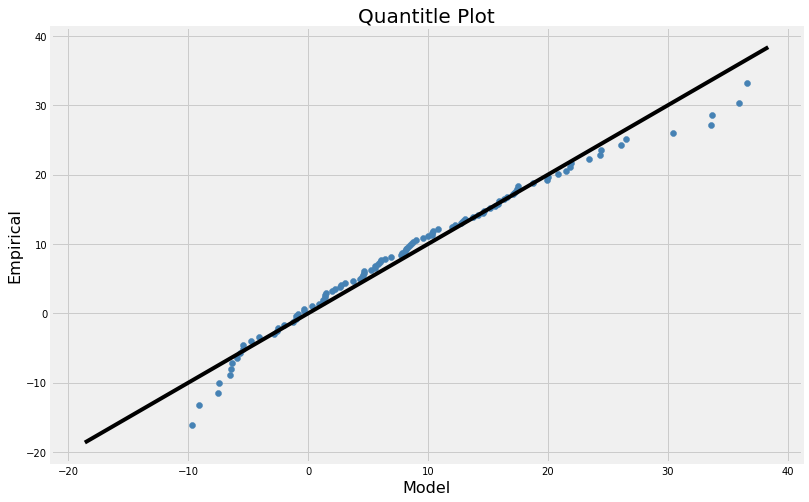

In [28]:
empirical = [stats.norm.ppf(q=(i+1)/(len(data_meas)+1), loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
plt.figure(figsize=(12, 8))
plt.scatter(np.sort(data_meas), empirical, color="steelblue")
xmin, xmax = plt.xlim()
ymin1, ymax1 = plt.ylim()
axmax = max([xmax, ymax1])
axmin = min([xmin, ymin1])
plt.plot(np.arange(axmin, axmax), np.arange(axmin, axmax), label="y=x", color="black")
plt.title("Quantitle Plot", fontsize=20)
plt.xlabel("Model", fontsize=16)
plt.ylabel("Empirical", fontsize=16)
# plt.legend(loc="best")
plt.show()

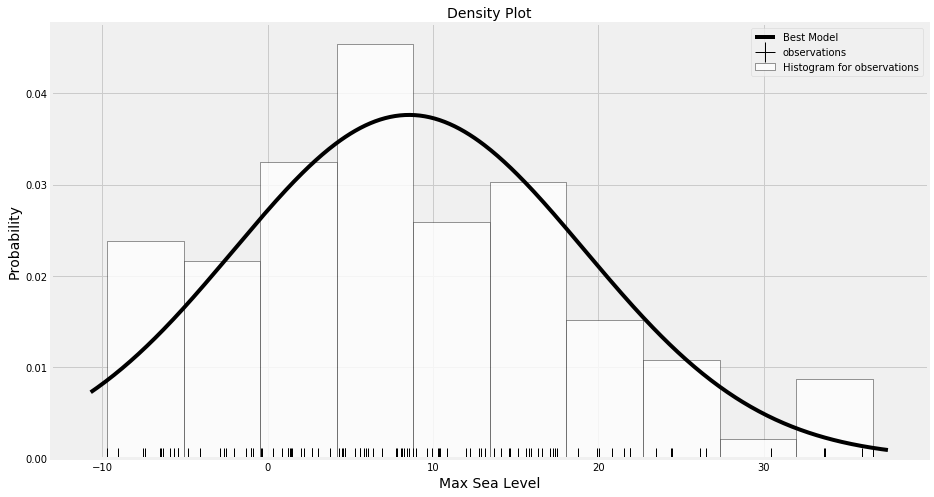

In [31]:
x_range = np.arange(min(data_meas)-1, max(data_meas)+1, 0.1)
y_range = [stats.norm.pdf(x=xi, loc=max_params[0], scale=max_params[1]) for xi in x_range]
plt.figure(figsize=(14,8))
plt.hist(data_meas, normed=True, edgecolor="black", label="Histogram for observations", color="white", alpha=0.8)
plt.plot(x_range, y_range, label="Best Model", color="black")
plt.plot(data_meas, np.zeros_like(data_meas), "b+", ms=20, color="black", label="observations")
plt.legend()
plt.title("Density Plot", fontsize=14)
plt.xlabel("Max Sea Level", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.show()

***